# Train the Model

This is where the real work happens, training the model. With the training data already organized, we are going to examine a few properties of the training data, find an acceptable learning rate, _train a model_, and save it so we can revisit it later. In this example, we are going to use a `SingleShotDetector` (SSD) model availabe in the `arcgis.learn` module. This _object detection_ model uses a pretrained convulutional neural network, ResNet101, acting as the 'backbone'. More information about SSD is available in the [documentation](https://developers.arcgis.com/python/guide/how-ssd-works/).

In [13]:
from pathlib import Path

from arcgis.learn import SingleShotDetector, prepare_data
import pandas as pd

In [2]:
dir_prj = Path.cwd().parent
dir_data = dir_prj/'data'
dir_raw = dir_data/'raw'

dir_training = dir_raw/'training_data'

dir_models = dir_prj/'models'

assert dir_training.exists(), 'Please go back and run "01-procure-data.ipynb" to download, extract, and organize the training data.'

## Prepare Data into a DataBunch

To train the model, we need to first prepare the data by loading it into a DataBunch using the `prepare_data` method. This method takes path to training data and creates a Fast.AI DataBunch with specified transformation, batch size, split percentage, etc.

In [3]:
data = prepare_data(dir_training,
                    batch_size=8,
                    chip_size=500,
                    seed=42,
                    dataset_type='PASCAL_VOC_rectangles')

## Explore the Data

We can use the `classes` attribute of the data object to get information about the number of classes. These classes correlate directly to pavement crack classes we need to detect.

In [4]:
data.classes 

['background', 'D00', 'D01', 'D10', 'D11', 'D20', 'D30', 'D40', 'D43', 'D44']

To get a sense of what the training data looks like, ``arcgis.learn.show_batch()`` method randomly picks a few training chips and shows them to us.

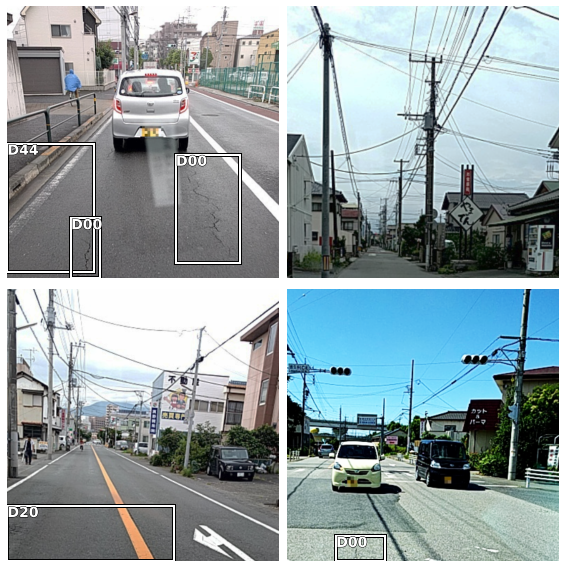

In [5]:
data.show_batch(rows=2)

## Load the Model Architecture

Now, we can load `SingleShotDetector` to train the damage detection model with a `resnet101` backbone.

In [6]:
ssd = SingleShotDetector(data, backbone='resnet101', focal_loss=True)

ssd

<SingleShotDetector>

First, we can take a look at how the model performs without any training. The results are...interesting.

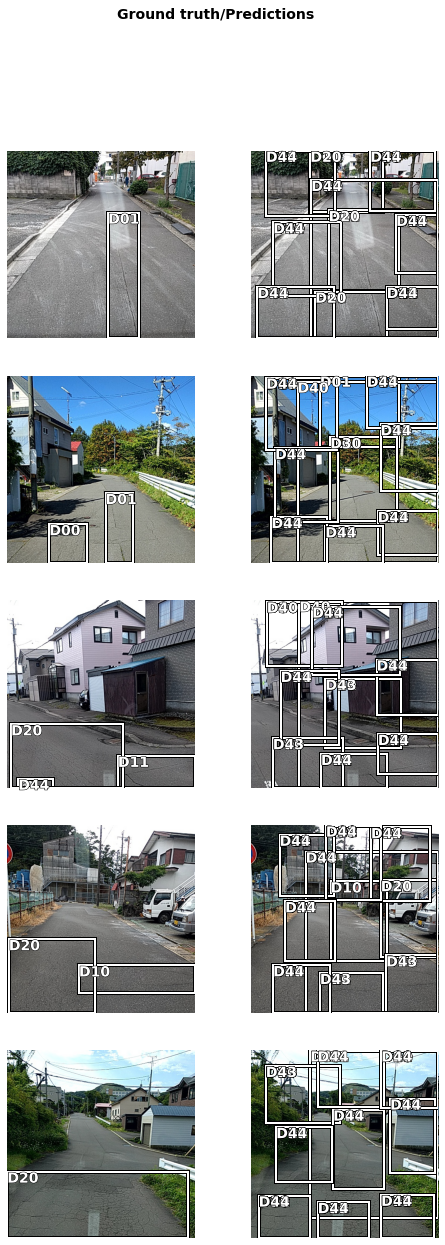

In [7]:
ssd.show_results(thresh=0.2)

For good results our model obviously needs to be trained.

## Select a Learning Rate

Learning rate is one of the most important hyperparameters in model training. Fortunately, we have a function available, inherited from Fast.AI, `lr_find`, we can use to find the optimal learning rate to strike the balance between a robust model, and the time it takes to train the model.

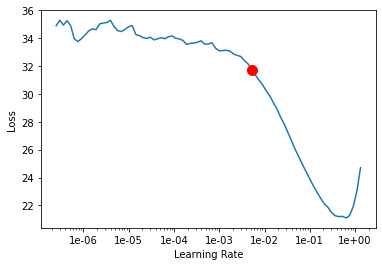

Wall time: 1min 13s


In [8]:
%%time

lr = ssd.lr_find()

## Train the model

Using the learning rate provided by `lr_find`, we can now train the model. In the interest of getting this done before Christmas (it's 20 Dec as I write this), we are going to just use 30 epocs (single complete pass through the data). 

My reccomendation is to start this at the end of the day, and let it run overnight. This is what I did. Come back in the morning and check out your results.

In [9]:
%%time

ssd.fit(30, lr=lr)

epoch,train_loss,valid_loss,time
0,2.147830,4.009970,13:09
1,1.822178,1.733773,12:48
2,1.654492,1.568262,12:39
3,1.578107,205.681870,12:39
4,1.673492,17346.085938,12:40
5,1.511886,64030.621094,12:46
6,1.448904,3386.239502,12:37
7,1.420612,4979.301270,12:33
8,1.397590,25062.232422,12:36
9,1.360274,5916.413574,12:44


Wall time: 6h 22min 18s


## Evaluate Performance

The graph below plots training and validation losses. 

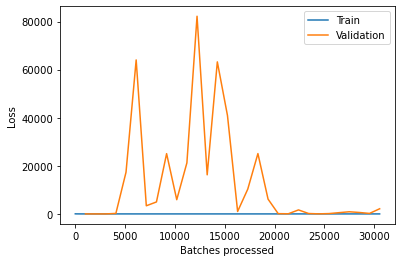

In [10]:
ssd.learn.recorder.plot_losses()

``average_precision_score`` method computes average precision on the validation set for each class.

In [11]:
ssd.average_precision_score() 

{'D00': 0.0012762237432041579,
 'D01': 0.04856298930322289,
 'D10': 0.0,
 'D11': 0.0,
 'D20': 0.29092844206219315,
 'D30': 0.0,
 'D40': 0.0,
 'D43': 0.1359788394833683,
 'D44': 0.039555671863402475}

We can see the model accuracy for each class of our validation data. The model is giving varying results. 
Let's us dig deeper to find the reason for model to preform better on one class in comparison to the other. 
This will also help us understand why D30 class has zero average precision score. 

In [14]:
# Calculate the number of images of each classs in training data
all_classes = []
for i, bb in enumerate(data.train_ds.y):
    all_classes += bb.data[1].tolist()
    
df = pd.value_counts(all_classes, sort=False)
df.index = [data.classes[i] for i in df.index] 
df   

D43     754
D00    2477
D44    3369
D01    3418
D10     677
D11     574
D20    2291
D30      22
D40     369
dtype: int64

We have only 22 images for training our model to detect class D30, which, for supervised deep learning, is very litlte. Thus, the model is returnign a very poor score for this specific class. If this is something we need to perform better, we need to procure more training data withe D30 samples.

## Evalute Results Against a Validation Set

One of most important steps in training a machine learning model is evaluating the results, determining how well the model is performing. We can do this using the `show_results` method.

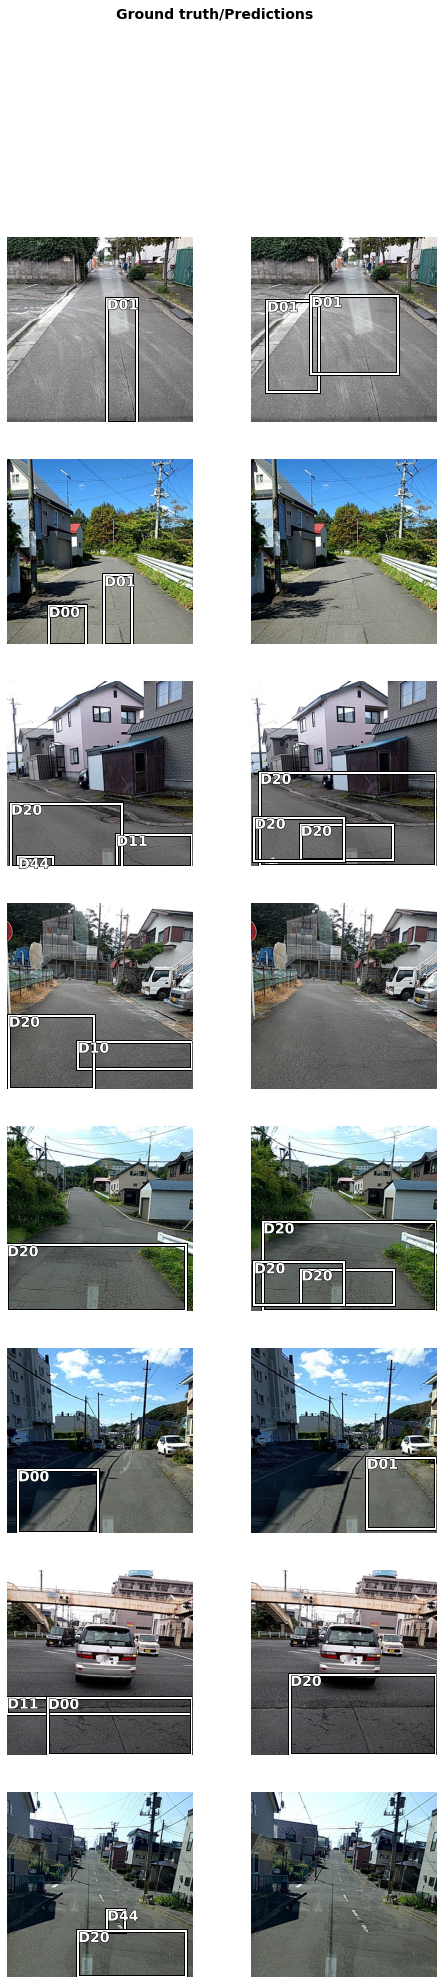

In [15]:
ssd.show_results(rows=10, thresh=0.2, nms_overlap=0.5)

### Save the model

As we can see, with 30 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your data_path that you specified in the very beginning of this notebook.

In [ ]:
dir_models = dir_prj/'models'

ssd.save(str(dir_models / 'pavement-cracks-model-resnet101'))